### Implementing simple Chatbot Using LangGraph

In [1]:
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END

## Reducers
from typing import Annotated
from langgraph.graph.message import add_messages

In [2]:
class State(TypedDict):
    messages:Annotated[list,add_messages]

In [3]:
import os
from dotenv import load_dotenv
load_dotenv()

os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")


In [4]:
from langchain_openai import ChatOpenAI
llm=ChatOpenAI(model="gpt-4o")
llm.invoke("Hello")

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 8, 'total_tokens': 17, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_07871e2ad8', 'id': 'chatcmpl-BmzXq9YVcp2UQ5KoHeWJIY9FT11hB', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--f1680580-4126-48ce-903c-1d250efa65bf-0', usage_metadata={'input_tokens': 8, 'output_tokens': 9, 'total_tokens': 17, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [5]:
from langchain_groq import ChatGroq

llm_groq=ChatGroq(model="qwen-qwq-32b")
llm_groq.invoke("Hey I am Krish and i like to play cricket")

AIMessage(content="\n<think>\nOkay, the user is Krish who likes to play cricket. Let me think about how to respond. First, I should acknowledge his interest in cricket because that's a common ground. Maybe mention a popular cricketer or a recent event to connect with him. Since he's sharing personal info, asking a question about his experience could be good. I should keep the tone friendly and engaging. Let me check if there are recent cricket events, but since I don't have real-time data, I can talk about general topics like favorite players or positions. Also, maybe ask about his favorite part of playing cricket. Need to make sure the response is open-ended to encourage further conversation.\n</think>\n\nThat's awesome, Krish! Cricket is such a thrilling sport. Do you prefer batting or bowling? Also, who's your favorite cricket player and why? If you don't mind me asking, do you play in a local team or just for fun? 😊 Let me know—I’m curious to hear more about your cricket adventures

### We Will start With Creating Nodes

In [6]:
from langgraph.checkpoint.memory import MemorySaver
memory=MemorySaver()
def superbot(state:State):
    return {"messages":[llm_groq.invoke(state['messages'])]}

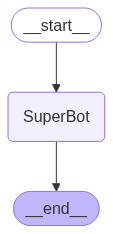

In [7]:
graph=StateGraph(State)

## node
graph.add_node("SuperBot",superbot)
## Edges

graph.add_edge(START,"SuperBot")
graph.add_edge("SuperBot",END)


graph_builder=graph.compile(checkpointer=memory)


## Display
from IPython.display import Image, display
display(Image(graph_builder.get_graph().draw_mermaid_png()))

In [8]:
## Invocation

config = {"configurable": {"thread_id": "1"}}

graph_builder.invoke({'messages':"Hi,My name is Krish And I like cricket"},config)

{'messages': [HumanMessage(content='Hi,My name is Krish And I like cricket', additional_kwargs={}, response_metadata={}, id='edbca794-a3f0-4046-9bbf-1032faa9d88a'),
  AIMessage(content="\n<think>\nOkay, the user introduced himself as Krish and mentioned he likes cricket. I should respond warmly. Let me start by greeting him and acknowledging his name. Then, express enthusiasm about his interest in cricket. Maybe ask him a question about his favorite team or player to keep the conversation going. Need to make sure the tone is friendly and approachable. Let me check if there are any current cricket events I can reference, like the ongoing World Cup or recent matches. Oh right, the ICC Men's T20 World Cup 2023 is happening now. That's a good point to bring up. I should also invite him to share more so he feels engaged. Alright, let's put that together in a natural way without being too verbose.\n</think>\n\nHi Krish! Nice to meet you! 🎯 Cricket is an amazing sport—I’m glad you enjoy it to

# I have commented below because the outputs are too long,seems not efficient to push to github,you can comment out and checkout the outputs

#### Streaming The Responses With Stream Method

In [9]:
# Create a thread
config = {"configurable": {"thread_id": "3"}}

for chunk in graph_builder.stream({'messages':"Hi,My name is Krish And I like cricket"},config,stream_mode="updates"):
    print(chunk)

{'SuperBot': {'messages': [AIMessage(content="\n<think>\nOkay, the user introduced themselves as Krish and mentioned they like cricket. I should respond in a friendly way. Let me start by greeting them back and acknowledging their name and interest. Maybe ask a follow-up question to keep the conversation going. I can mention some popular cricket teams or players to engage them. I should keep it casual and positive. Let me check if there's anything else to add. Hmm, maybe ask if they follow any particular team or player. Yeah, that sounds good. Let me put that together in a natural way without any errors.\n</think>\n\nHello Krish! Nice to meet you. That's great you like cricket—I’m a big fan too! Do you follow any particular cricket teams or players? If you’re interested, I can share some fun facts about the sport or even recommend some classic matches to watch. Let me know! 😊", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 175, 'prompt_tokens': 20, 'tota

In [14]:
''' for chunk in graph_builder.stream({'messages':"I also like football"},config,stream_mode="values"):
    print(chunk)'''

' for chunk in graph_builder.stream({\'messages\':"I also like football"},config,stream_mode="values"):\n    print(chunk)'

In [15]:
'''for chunk in graph_builder.stream({'messages':"I also like football "},config,stream_mode="updates"):
    print(chunk)'''

'for chunk in graph_builder.stream({\'messages\':"I also like football "},config,stream_mode="updates"):\n    print(chunk)'

In [16]:
'''for chunk in graph_builder.stream({'messages':"I Love sports "},config,stream_mode="values"):
    print(chunk)'''

'for chunk in graph_builder.stream({\'messages\':"I Love sports "},config,stream_mode="values"):\n    print(chunk)'

#### Streaming The Responses With astream Method

**Streaming tokens**
We often want to stream more than graph state.

In particular, with chat model calls it is common to stream the **tokens** as they are generated.

We can do this using the .astream_events method, which streams back events as they happen inside nodes!

Each event is a dict with a few keys:

- event: This is the type of event that is being emitted.
- name: This is the name of event.
- data: This is the data associated with the event.
- metadata: Containslanggraph_node, the node emitting the event.

In [17]:
config = {"configurable": {"thread_id": "3"}}

'''async for event in graph_builder.astream_events({"messages":["Hi My name is Krish and I like to play cricket"]},config,version="v2"):
    print(event)'''

'async for event in graph_builder.astream_events({"messages":["Hi My name is Krish and I like to play cricket"]},config,version="v2"):\n    print(event)'